In [292]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from scipy.stats import chi2_contingency
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import cross_validate, KFold
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score


In [268]:
df2=pd.read_csv('/home/alexander/432/2024_bank_marketing.csv',sep=';')
for i,r in df2.iterrows():
    if(r.isna().any()):
        print(f"Row {r['id']} contains missing value, row dropped")
        df2.drop(i,inplace=True)
len(df2)

Row 358 contains missing value, row dropped


39999

In [32]:
df=pd.read_csv('/home/alexander/432/2024_bank_marketing.csv',sep=';')
features = ['age','duration', 'campaign', 'pdays', 'emp.var.rate', 
                      'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed','previous']
categorical= ['job', 'marital', 'education', 'default', 'housing', 'loan', 
                                  'contact', 'month', 'day_of_week', 'poutcome','subscription']
for feature in categorical:
    df.drop(columns=feature,inplace=True)
for i,r in df.iterrows():
    if(r.isna().any()):
        print(f"Row {r['id']} contains missing value, row dropped")
        df.drop(i,inplace=True)
df

Row 358.0 contains missing value, row dropped


,id,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,0,56,261,1,999.0,0,1.1,93.994,-36.4,4.857,5191.0
1,1,57,149,1,999.0,0,1.1,93.994,-36.4,4.857,5191.0
2,2,37,226,1,999.0,0,1.1,93.994,-36.4,4.857,5191.0
3,3,40,151,1,999.0,0,1.1,93.994,-36.4,4.857,5191.0
4,4,56,307,1,999.0,0,1.1,93.994,-36.4,4.857,5191.0
...,...,...,...,...,...,...,...,...,...,...,...
39995,39995,31,354,1,999.0,0,1.4,93.918,-42.7,4.960,5228.1
39996,39996,39,73,1,999.0,0,-0.1,93.200,-42.0,4.120,5195.8
39997,39997,49,57,1,999.0,0,1.1,93.994,-36.4,4.856,5191.0
39998,39998,44,283,1,999.0,0,-2.9,92.201,-31.4,0.825,5076.2


In [293]:
pca=PCA(n_components=3)
scale=StandardScaler()
scaled=scale.fit_transform(df)
principal=pca.fit_transform(scaled)
df_pca=pd.DataFrame(data=principal,columns=['PC1','PC2','PC3'])
df_pca
df_pca_unormalized=df_pca.copy()

In [34]:
PCA_features=['PC1','PC2','PC3']
for feature in PCA_features:
    min_value = df_pca[feature].min()
    max_value = df_pca[feature].max()
    scaler=MinMaxScaler()
    df_pca[feature] = scaler.fit_transform(df_pca[[feature]])
    print(f"Feature: {feature}")
    print(f"Original range: [{min_value}, {max_value}]")
    print(f"Normalized range: [{df_pca[feature].min()}, {df_pca[feature].max()}]\n")
df_pca


Feature: PC1
Original range: [-7.3414337197392365, 3.2883597564403635]
Normalized range: [0.0, 1.0]

Feature: PC2
Original range: [-9.702270742070791, 2.4577184224062387]
Normalized range: [0.0, 1.0]

Feature: PC3
Original range: [-7.086854800813248, 5.976024595211865]
Normalized range: [0.0, 1.0]



,PC1,PC2,PC3
0,0.810013,0.723944,0.646583
1,0.811039,0.724847,0.647994
2,0.810537,0.762893,0.559112
3,0.811200,0.758832,0.570665
4,0.809587,0.722751,0.647875
...,...,...,...
39994,0.826544,0.820708,0.502877
39995,0.701536,0.852655,0.569863
39996,0.812170,0.743071,0.627748
39997,0.418534,0.838624,0.736287


In [ ]:
def rand_center(data,k):
    """
    >>> Function you need to write
    >>> Select "k" random points from "data" as the initial centroids.
    """
    rand_points = np.random.choice(data.shape[0], k, replace=False)
    return rand_points
    pass
def converged(centroids1, centroids2):
    """
    >>> Function you need to write
    >>> check whether centroids1==centroids2
    >>> add proper code to handle infinite loop if it never converges
    """
    for i in range(len(centroids1)):
        if not np.array_equal(centroids1[i], centroids2[i]):
            return False
    return True
    pass
def update_centroids(data, centroids,k):
    """
    >>> Function you need to write
    >>> Assign each data point to its nearest centroid based on the Euclidean dis
    tance
    >>> Update the cluster centroid to the mean of all the points assigned to tha
    t cluster
    """
    clusters=[]
    new_centroids = []
    distances=[]
    for _, point in data.iterrows():  
        distances=[]
        for cid in centroids: 
            # Extract the centroid 
            #initial case
            if(type(cid)==np.int64):
                centroid = data.iloc[cid].values  
            #general case
            else:
                centroid = cid
            # Calculate distance
            distances.append(np.linalg.norm(point.values - centroid))  
        # Assign the point to the closest centroid
        clusters.append(np.argmin(distances))

    
    # Update the centroids
    for i in range(k):        
        cluster_points = data.iloc[[idx for idx, label in enumerate(clusters) if label == i]] 
        new_centroids.append(cluster_points.mean(axis=0).values)
    return new_centroids, clusters
    pass

def kmeans(data,k=5):
    """
    >>> Main function of your k-Means implementation
    """
    # step 1:
    centroids = rand_center(data,k)
    #print(centroids)
    converge = False
    while not converge:
        old_centroids = np.copy(centroids)
        # step 2 & 3; labels can be an array of labels for all the data points
        centroids, label = update_centroids(data, old_centroids,k)
        # step 4
        converge = converged(old_centroids, centroids)
    #print(">>> final centroids")
    #print(centroids)
    return centroids, label


In [66]:
result1=[]
result2=[]
result1,result2=kmeans(df_pca)
print(">>> final Results")
print("centroids:",result1)
print("Labels:",result2)

>>> final Results
centroids: [array([0.47740786, 0.89721892, 0.51641815]), array([0.41133585, 0.79171832, 0.69713158]), array([0.69220557, 0.82993562, 0.55491677]), array([0.83132998, 0.77747808, 0.54254683]), array([0.26583675, 0.44500362, 0.43325514])]
Labels: [np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(1), np.int64(3), np.int64(3), np.int64(0), np.int64(0), np.int64(3), np.int64(3), np.int64(3), np.int64(2), np.int64(3), np.int64(3), np.int64(0), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(1), np.int64(1), np.int64(3), np.int64(3), np.int64(0), np.int64(0), np.int64(3), np.int64(3), np.int64(3), np.int64(1), np.int64(3), np.int64(0), np.int64(0), np.int64(3), np.int64(0), np.int64(0), np.int64(0), np.int64(3), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(4), np.int64(3), np.int64(3), np.int64(2), np.int64(0), np.int64(0), np.int64

In [ ]:

def sep_groups(data,l,target,final_index,iter):
    sub1_0=[]
    sub2_1=[]
    id1=[]
    id2=[]
    index2=0
    #assign indexes based on labels
    if(iter==0):
        #initial case
        for i in range(len(data)):
            if(int(l[i])==0):
                id1.append(i)
            
                final_index[int(i)]=0
            else:
                id2.append(i)
                final_index[int(i)]=1
            index2+=1
    else:
        # general case
        for i in target:
            if(int(l[index2])==0):
                id1.append(i)
                
                final_index[int(i)]=0+iter
            else:
                id2.append(i)
                final_index[int(i)]=1+iter
            index2+=1
    l = np.array(l)
  
    #seperate out the data based on labels
    sub1_0 = data[l == 0]
    sub2_1 = data[l == 1]
    
    return sub1_0, sub2_1,id1,id2
#comments are under optimized version
def bisecting_kmeans(data,k=5,trials=1):
    c=[]
    l=[]
    final_index=[-1]*len(data)
    target=[]
    clusters=[]
    label1=[]
    label2=[]
    target_label=[]
    iter=0
    while(len(clusters)<k-1):
        if(len(clusters)==0):
            c,l=kmeans(data,k=2)
            sub1,sub2,label1,label2=sep_groups(data,l,l,final_index,iter)
            
        else:
            c,l=kmeans(target,k=2)
            sub1,sub2,label1,label2=sep_groups(target,l,target_label,final_index,iter)
        
        
    
        if(len(sub1)>= len(sub2)):
            target=sub1
            target_label=label1
            clusters.append(c[1])
            flag=True
            
        else:
            target=sub2
            target_label=label2
            clusters.append(c[0])
            flag=False
        if(len(clusters)!=k-1):
                for i in label2:
                    final_index[i]=0+iter
        iter+=1
    if(flag==True):
        clusters.append(c[0])
    else:
        clusters.append(c[1])
    return clusters,final_index


            
            

In [257]:
result,label=bisecting_kmeans(df_pca,k=5)

In [258]:

label2=np.array(label)
invalid_values = label2[(label2 < 0) | (label2 > 4)]
if len(invalid_values) > 0:
    print("Invalid Values Found:", invalid_values)
    print("Their Indices:", np.where((label2 < 0) | (label2 > 4)))
print("Clusters:",result)
print("Labels:",label)


Clusters: [array([0.44091277, 0.82544719, 0.539134  ]), array([0.84589199, 0.79935869, 0.48330213]), array([0.69166272, 0.82935132, 0.55659239]), array([0.8155003 , 0.74321354, 0.62941793]), array([0.82176428, 0.77147517, 0.56355294])]
Labels: [3, 3, 4, 4, 3, 0, 3, 3, 0, 0, 3, 1, 4, 2, 1, 4, 0, 1, 1, 1, 1, 1, 0, 0, 3, 1, 0, 0, 3, 1, 4, 0, 3, 0, 0, 1, 0, 0, 0, 4, 0, 0, 0, 0, 1, 1, 4, 4, 3, 4, 0, 4, 1, 2, 0, 0, 0, 0, 0, 4, 0, 0, 2, 1, 1, 1, 1, 1, 1, 0, 0, 2, 1, 1, 0, 1, 1, 1, 1, 2, 4, 1, 4, 1, 2, 4, 3, 0, 3, 0, 0, 1, 4, 0, 1, 0, 1, 4, 0, 0, 1, 1, 0, 2, 2, 0, 4, 1, 1, 0, 4, 4, 1, 1, 0, 1, 4, 0, 1, 0, 0, 4, 4, 1, 2, 2, 4, 0, 0, 4, 2, 3, 3, 1, 1, 1, 0, 3, 0, 4, 4, 0, 4, 2, 0, 4, 3, 1, 0, 3, 1, 0, 0, 0, 0, 1, 3, 4, 1, 0, 4, 2, 3, 4, 0, 0, 1, 3, 1, 4, 4, 1, 0, 2, 4, 0, 1, 1, 1, 0, 0, 3, 4, 1, 1, 1, 1, 0, 0, 0, 3, 0, 1, 1, 3, 1, 0, 4, 2, 0, 1, 3, 0, 1, 3, 4, 0, 4, 0, 3, 4, 1, 4, 1, 4, 1, 4, 1, 0, 0, 0, 0, 4, 1, 3, 0, 3, 4, 1, 0, 1, 0, 1, 2, 4, 2, 0, 1, 1, 1, 0, 1, 0, 4, 4, 1, 0, 3, 3, 0, 1, 1,

In [ ]:
def SSE(centroids,label,data):
    sse=0
    for i in range(len(data)):
        #SSE formula
        sse+=np.linalg.norm(data.iloc[i].values-centroids[int(label[i])])**2
    return sse

In [ ]:

def bisecting_kmeans_optimize(data,k=5,trials=1):
    c=[]
    l=[]
    final_index=[-1]*len(data)
    target=[]
    clusters=[]
    label1=[]
    label2=[]
    target_label=[]
    iter=0
    min_SSE=-1
    temp_c,temp_l=[],[]
    #enough clusters have been created->ending cond
    while(len(clusters)<k-1):
        #intial case
        if(len(clusters)==0):
            #run kmeans trials times and select the one with the lowest SSE
            for i in range(trials):
                temp_c,temp_l=kmeans(data,k=2)
                eval=SSE(temp_c,temp_l,data)
                if(eval<min_SSE or min_SSE==-1):
                    min_SSE=eval
                    c=temp_c
                    l=temp_l
            #separate the data into two groups and organize labels
            sub1,sub2,label1,label2=sep_groups(data,l,l,final_index,iter)
        #general entry
        else:
            for i in range(trials):
                temp_c,temp_l=kmeans(target,k=2)
                eval=SSE(temp_c,temp_l,target)
                if(eval<min_SSE or min_SSE==-1):
                    min_SSE=eval
                    c=temp_c
                    l=temp_l
            sub1,sub2,label1,label2=sep_groups(target,l,target_label,final_index,iter)
        
        
        #choose target based on splitting condition
        if(len(sub1)>= len(sub2)):
            target=sub1
            target_label=label1
            clusters.append(c[1])
            flag=True
        else:
            target=sub2
            target_label=label2
            clusters.append(c[0])
            flag=False
        #force the minor cluster to obtain the lowest label possible within the current step to prevent label overlap
        if(len(clusters)!=k-1):
                for i in label2:
                    final_index[i]=0+iter
        iter+=1
    if(flag==True):
        clusters.append(c[0])
    else:
        clusters.append(c[1])
    return clusters,final_index

      
            
            

In [ ]:
#normal section code/reuslt
#remember to remove tests
c_bopt,l_bopt=bisecting_kmeans_optimize(df_pca,k=5,trials=5)
l_bopt2=np.array(l_bopt)
invalid_values = l_bopt2[(l_bopt2 < 0) | (l_bopt2 > 4)]
if len(invalid_values) > 0:
    print("Invalid Values Found:", invalid_values)
    print("Their Indices:", np.where((l_bopt2 < 0) | (l_bopt2 > 4)))
print("Clusters:",c_bopt)
print("Labels:",l_bopt)
print("SSE:",SSE(c_bopt,l_bopt,df_pca))

Clusters: [array([0.44091277, 0.82544719, 0.539134  ]), array([0.84589199, 0.79935869, 0.48330213]), array([0.69166272, 0.82935132, 0.55659239]), array([0.8155003 , 0.74321354, 0.62941793]), array([0.82176428, 0.77147517, 0.56355294])]
Labels: [3, 3, 4, 4, 3, 0, 3, 3, 0, 0, 3, 1, 4, 2, 1, 4, 0, 1, 1, 1, 1, 1, 0, 0, 3, 1, 0, 0, 3, 1, 4, 0, 3, 0, 0, 1, 0, 0, 0, 4, 0, 0, 0, 0, 1, 1, 4, 4, 3, 4, 0, 4, 1, 2, 0, 0, 0, 0, 0, 4, 0, 0, 2, 1, 1, 1, 1, 1, 1, 0, 0, 2, 1, 1, 0, 1, 1, 1, 1, 2, 4, 1, 4, 1, 2, 4, 3, 0, 3, 0, 0, 1, 4, 0, 1, 0, 1, 4, 0, 0, 1, 1, 0, 2, 2, 0, 4, 1, 1, 0, 4, 4, 1, 1, 0, 1, 4, 0, 1, 0, 0, 4, 4, 1, 2, 2, 4, 0, 0, 4, 2, 3, 3, 1, 1, 1, 0, 3, 0, 4, 4, 0, 4, 2, 0, 4, 3, 1, 0, 3, 1, 0, 0, 0, 0, 1, 3, 4, 1, 0, 4, 2, 3, 4, 0, 0, 1, 3, 1, 4, 4, 1, 0, 2, 4, 0, 1, 1, 1, 0, 0, 3, 4, 1, 1, 1, 1, 0, 0, 0, 3, 0, 1, 1, 3, 1, 0, 4, 2, 0, 1, 3, 0, 1, 3, 4, 0, 4, 0, 3, 4, 1, 4, 1, 4, 1, 4, 1, 0, 0, 0, 0, 4, 1, 3, 0, 3, 4, 1, 0, 1, 0, 1, 2, 4, 2, 0, 1, 1, 1, 0, 1, 0, 4, 4, 1, 0, 3, 3, 0, 1, 1,

In [302]:
#bonus section code/reuslt
c_bopt,l_bopt=bisecting_kmeans_optimize(df_pca_unormalized,k=5,trials=5)
l_bopt2=np.array(l_bopt)
invalid_values = l_bopt2[(l_bopt2 < 0) | (l_bopt2 > 4)]
if len(invalid_values) > 0:
    print("Invalid Values Found:", invalid_values)
    print("Their Indices:", np.where((l_bopt2 < 0) | (l_bopt2 > 4)))
print("Clusters:",c_bopt)
print("Labels:",l_bopt)
print("SSE:",SSE(c_bopt,l_bopt,df_pca))

Clusters: [array([-2.65413958,  0.33536766, -0.0441899 ]), array([ 1.51847434,  0.06060049, -0.7539795 ]), array([0.01794245, 0.33338894, 0.37765949]), array([ 1.32579424, -0.66541231,  1.14563247]), array([ 1.40820589, -0.33187191,  0.28537376])]
Labels: [3, 3, 4, 4, 3, 0, 3, 3, 0, 0, 3, 1, 4, 2, 1, 4, 0, 1, 1, 1, 1, 1, 0, 0, 3, 1, 0, 0, 3, 1, 4, 0, 3, 0, 0, 1, 0, 0, 0, 4, 0, 0, 0, 0, 1, 1, 4, 1, 3, 4, 0, 4, 1, 2, 0, 0, 0, 0, 0, 4, 0, 0, 2, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 2, 4, 1, 4, 1, 2, 4, 3, 0, 3, 0, 0, 1, 4, 0, 1, 0, 1, 4, 0, 0, 1, 1, 0, 2, 2, 0, 4, 1, 1, 0, 1, 4, 1, 1, 0, 1, 4, 0, 1, 0, 0, 4, 4, 1, 2, 2, 4, 0, 0, 4, 1, 3, 3, 1, 1, 4, 0, 3, 0, 4, 4, 0, 4, 1, 0, 4, 3, 1, 0, 3, 1, 0, 0, 0, 0, 1, 3, 4, 1, 0, 4, 1, 3, 4, 0, 0, 1, 3, 1, 4, 4, 1, 0, 2, 4, 0, 1, 1, 1, 0, 0, 4, 4, 1, 1, 1, 1, 0, 0, 0, 3, 0, 1, 1, 3, 1, 0, 4, 2, 0, 1, 3, 0, 1, 3, 4, 0, 4, 0, 3, 4, 1, 4, 1, 4, 1, 4, 1, 0, 0, 0, 0, 4, 1, 3, 0, 3, 4, 1, 0, 1, 0, 1, 1, 4, 2, 0, 1, 1, 1, 0, 1, 0, 4, 4, 1, 0, 3,

In [ ]:
#normal section code/result
final_cluster,final_label=[],[]
min_SSE=-1
#run k-means 20 times
for i in range(20):
    cluster_temp,label_temp=kmeans(df_pca,k=5)
    eval_2=SSE(cluster_temp,label_temp,df_pca)
    if(eval_2<min_SSE or min_SSE==-1):
        min_SSE=eval_2
        final_cluster=cluster_temp
        final_label=label_temp
print("Final Clusters:",final_cluster)
print("Final Labels:",final_label)
print("SSE_min:",min_SSE)
    

Final Clusters: [array([0.7932539 , 0.77534949, 0.5807916 ]), array([0.41133585, 0.79171832, 0.69713158]), array([0.84589001, 0.79936285, 0.48329554]), array([0.26583675, 0.44500362, 0.43325514]), array([0.47757161, 0.89721121, 0.51646037])]
Final Labels: [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(4), np.int64(4), np.int64(0), np.int64(2), np.int64(0), np.int64(0), np.int64(2), np.int64(0), np.int64(4), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(1), np.int64(1), np.int64(0), np.int64(2), np.int64(4), np.int64(4), np.int64(0), np.int64(2), np.int64(0), np.int64(1), np.int64(0), np.int64(4), np.int64(4), np.int64(2), np.int64(4), np.int64(4), np.int64(4), np.int64(0), np.int64(4), np.int64(1), np.int64(4), np.int64(4), np.int64(2), np.int64(2), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(3), np.int64(0), np.int64(2), np.int64(0), np.int64(4), np.int64(4), np.int64(4), np

In [295]:
#bonus code/reusult
final_cluster,final_label=[],[]
min_SSE=-1
#run k-means 20 times
for i in range(20):
    cluster_temp,label_temp=kmeans(df_pca_unormalized,k=5)
    eval_2=SSE(cluster_temp,label_temp,df_pca)
    if(eval_2<min_SSE or min_SSE==-1):
        min_SSE=eval_2
        final_cluster=cluster_temp
        final_label=label_temp
print("Final Clusters:",final_cluster)
print("Final Labels:",final_label)
print("SSE_min:",min_SSE)
    

Final Clusters: [array([ 1.1502749 , -0.31643142,  0.54925053]), array([-4.50836927, -4.27930861, -1.42815039]), array([-2.9496311 , -0.04597971,  2.0374556 ]), array([ 1.52282317,  0.05988201, -0.75637956]), array([-2.26875905,  1.2036451 , -0.34716874])]
Final Labels: [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(2), np.int64(0), np.int64(0), np.int64(4), np.int64(4), np.int64(0), np.int64(3), np.int64(0), np.int64(0), np.int64(3), np.int64(0), np.int64(4), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(2), np.int64(2), np.int64(0), np.int64(3), np.int64(4), np.int64(4), np.int64(0), np.int64(3), np.int64(0), np.int64(2), np.int64(0), np.int64(4), np.int64(4), np.int64(3), np.int64(4), np.int64(4), np.int64(4), np.int64(0), np.int64(4), np.int64(2), np.int64(4), np.int64(4), np.int64(3), np.int64(3), np.int64(0), np.int64(3), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(3), np.int64(0), np.int64(4), np.int64(4), 

In [ ]:
#NORMAL SECTION
kmeans_sklearn = KMeans(n_clusters=5) 
kmeans_sklearn.fit(df_pca)
labels_sklearn = kmeans_sklearn.labels_
centroids_sklearn = kmeans_sklearn.cluster_centers_
sse_sklearn = kmeans_sklearn.inertia_

print("Centroids (sklearn):", centroids_sklearn)
print("Labels (sklearn):", labels_sklearn)
print("SSE (sklearn):", sse_sklearn)

Centroids (sklearn): [[0.79307826 0.77531419 0.58104559]
 [0.41158872 0.79193645 0.69628665]
 [0.47763474 0.89734486 0.51630358]
 [0.84570699 0.79920586 0.48375149]
 [0.26574693 0.44487229 0.43321759]]
Labels (sklearn): [0 0 0 ... 0 1 0]
SSE (sklearn): 268.5861738311885


In [299]:
#BONUS SECTION
kmeans_sklearn = KMeans(n_clusters=5) 
kmeans_sklearn.fit(df_pca_unormalized)
labels_sklearn = kmeans_sklearn.labels_
centroids_sklearn = kmeans_sklearn.cluster_centers_
sse_sklearn = kmeans_sklearn.inertia_

print("Centroids (sklearn):", centroids_sklearn)
print("Labels (sklearn):", labels_sklearn)
print("SSE (sklearn):", sse_sklearn)

Centroids (sklearn): [[-2.94379402 -0.04077714  2.02099414]
 [ 1.13054224 -0.29521841  0.52086127]
 [-4.50915493 -4.28089062 -1.42888718]
 [-2.26810141  1.20616337 -0.35089516]
 [ 1.57633518  0.04735945 -0.78608467]]
Labels (sklearn): [1 1 1 ... 1 0 1]
SSE (sklearn): 39316.791976608


In [149]:
def plot_clusters(data, labels, centroids, title):
    centroids = np.array(centroids)
    print("Centroids shape:", centroids.shape)
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(data.iloc[:, 0].values, data.iloc[:, 1].values, data.iloc[:, 2].values, c=labels, cmap='viridis', s=50, label='Data Points')
    ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], c='red', s=200, marker='x', label='Centroids')
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    ax.set_zlabel('PC 3')
    ax.set_title(title)
    plt.legend()
    plt.show()


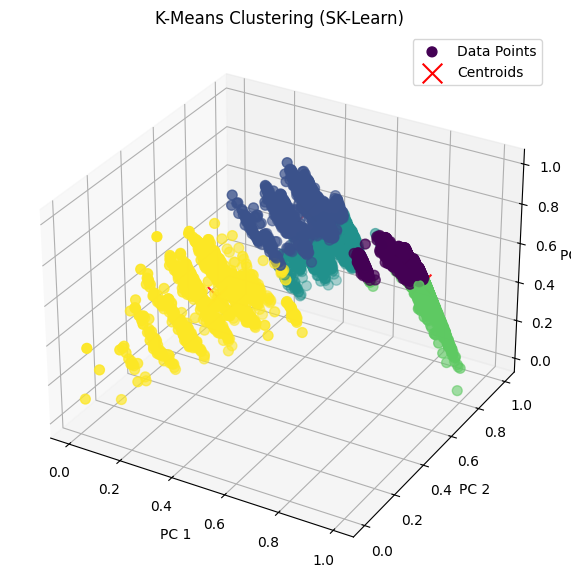

In [148]:
plot_clusters(df_pca, labels_sklearn, centroids_sklearn, 'K-Means Clustering (SK-Learn)')

Centroids shape: (5, 3)


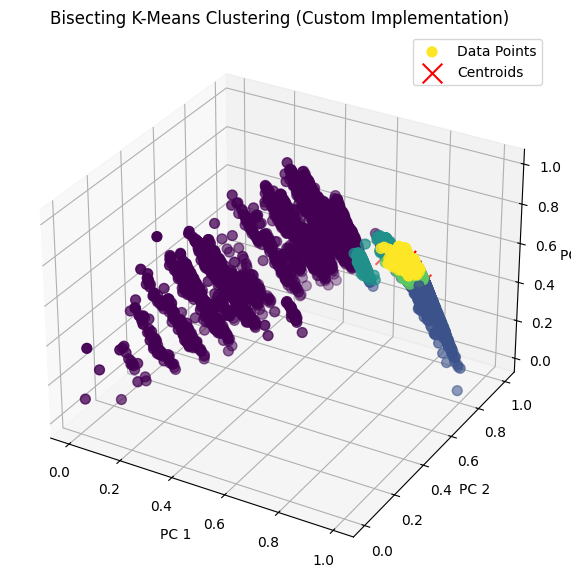

In [245]:

plot_clusters(df_pca, label,result, 'Bisecting K-Means Clustering (Custom Implementation)')

Centroids shape: (5, 3)


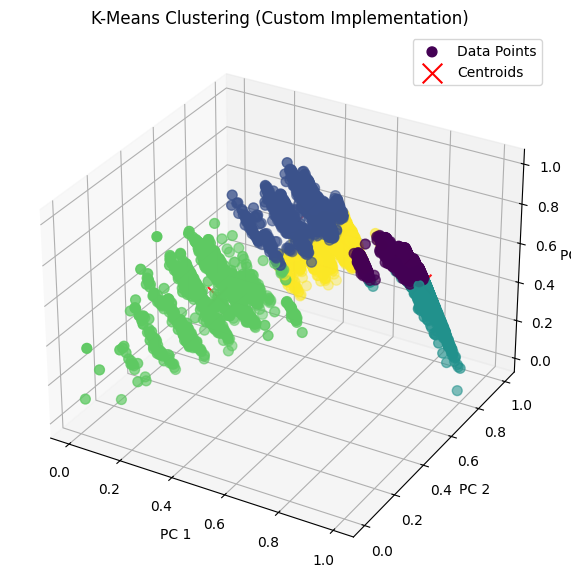

In [189]:
plot_clusters(df_pca, final_label,final_cluster, 'K-Means Clustering (Custom Implementation)')

Centroids shape: (5, 3)


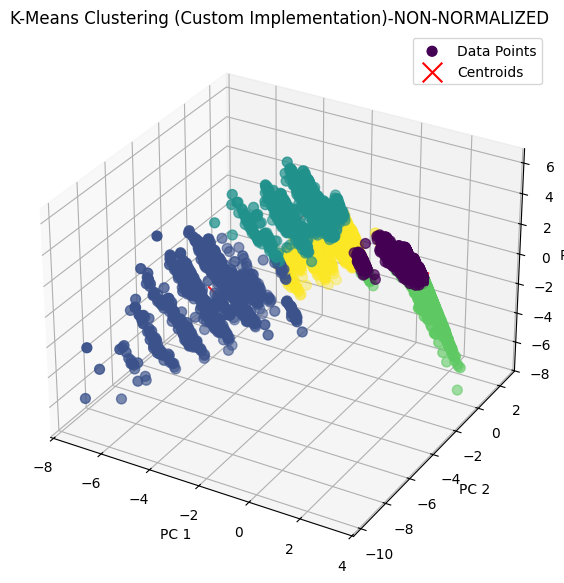

In [301]:
plot_clusters(df_pca_unormalized, final_label,final_cluster, 'K-Means Clustering (Custom Implementation)-NON-NORMALIZED')

In [272]:
def organize_clusters(data, labels):
    clusters = {}
    i=0
    
    for label in labels:
        if label not in clusters:
            clusters[int(label)] = pd.DataFrame(columns=data.columns)
        clusters[int(label)] = pd.concat([clusters[int(label)], data.iloc[[i]]], ignore_index=True)
        i+=1
    return clusters

In [273]:
print(len(df2))
clusters=organize_clusters(df2,final_label)

for i in clusters:
    print("Cluster:",i)
    summary=clusters[i]['subscription'].describe()
    print("Summary:",summary)

39999


/tmp/ipykernel_4175846/2077916494.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  clusters[int(label)] = pd.concat([clusters[int(label)], data.iloc[[i]]], ignore_index=True)
/tmp/ipykernel_4175846/2077916494.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  clusters[int(label)] = pd.concat([clusters[int(label)], data.iloc[[i]]], ignore_index=True)
/tmp/ipykernel_4175846/2077916494.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a 

Cluster: 0
Summary: count     16762
unique        2
top          no
freq      15878
Name: subscription, dtype: object
Cluster: 1
Summary: count     2359
unique       2
top         no
freq      1491
Name: subscription, dtype: object
Cluster: 4
Summary: count     9260
unique       2
top         no
freq      7876
Name: subscription, dtype: object
Cluster: 2
Summary: count     10081
unique        2
top          no
freq       9663
Name: subscription, dtype: object
Cluster: 3
Summary: count     1537
unique       2
top        yes
freq       952
Name: subscription, dtype: object


In [285]:
for i in clusters:
    print("Cluster:",i)
    df_sub=clusters[i]['subscription']
    clf = DecisionTreeClassifier(criterion='gini')
  
    clf.fit(df_sub.map({'no':0,'yes':1}).values.reshape(-1, 1), df_sub)
    print("Gini",clf.tree_.impurity[0])

Cluster: 0
Gini 0.09991400910927428
Cluster: 1
Gini 0.4651269272424693
Cluster: 4
Gini 0.25424347736846276
Cluster: 2
Gini 0.07948973103596413
Cluster: 3
Gini 0.471492810818293


In [ ]:
final_cluster,final_label=[],[]
min_SSE=-1
SSE_list=[]
#run k-means for k=2 to k=9
for i in range(2,10):
    cluster_temp,label_temp=kmeans(df_pca,k=i)
    eval_2=SSE(cluster_temp,label_temp,df_pca)
    SSE_list.append(eval_2)
    if(eval_2<min_SSE or min_SSE==-1):
        min_SSE=eval_2
        final_cluster=cluster_temp
        final_label=label_temp
print("Final Clusters:",final_cluster)
print("Final Labels:",final_label)
print("SSE_min:",min_SSE)
print("SSE_list:",SSE_list)

Final Clusters: [array([0.81622965, 0.74554602, 0.62391978]), array([0.82600556, 0.77467758, 0.55227617]), array([0.89249669, 0.80542825, 0.35835605]), array([0.47740786, 0.89721892, 0.51641815]), array([0.41133585, 0.79171832, 0.69713158]), array([0.69229934, 0.84086407, 0.52649751]), array([0.69167793, 0.81298421, 0.599412  ]), array([0.26583675, 0.44500362, 0.43325514]), array([0.84550424, 0.80496079, 0.47980476])]
Final Labels: [np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(4), np.int64(0), np.int64(0), np.int64(3), np.int64(3), np.int64(0), np.int64(8), np.int64(1), np.int64(6), np.int64(8), np.int64(1), np.int64(3), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(4), np.int64(4), np.int64(0), np.int64(1), np.int64(3), np.int64(3), np.int64(0), np.int64(1), np.int64(1), np.int64(4), np.int64(0), np.int64(3), np.int64(3), np.int64(8), np.int64(3), np.int64(3), np.int64(3), np.int64(1), np.int64(3), np.int64(4), np.int64(3), np.i

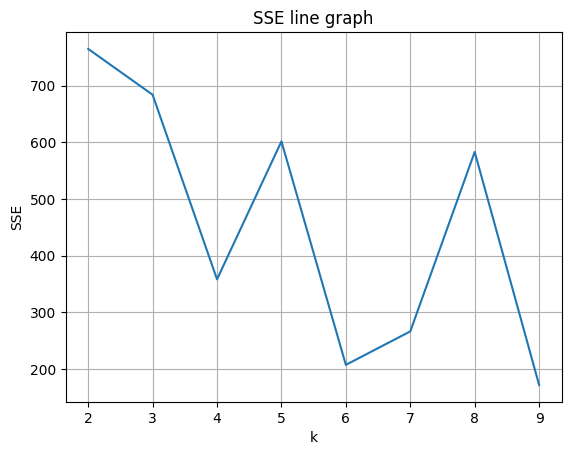

In [290]:
plt.plot(np.arange(2,10),SSE_list)
plt.title('SSE line graph')
plt.xlabel('k')
plt.ylabel('SSE')
plt.grid(True)
plt.show()

Centroids shape: (9, 3)


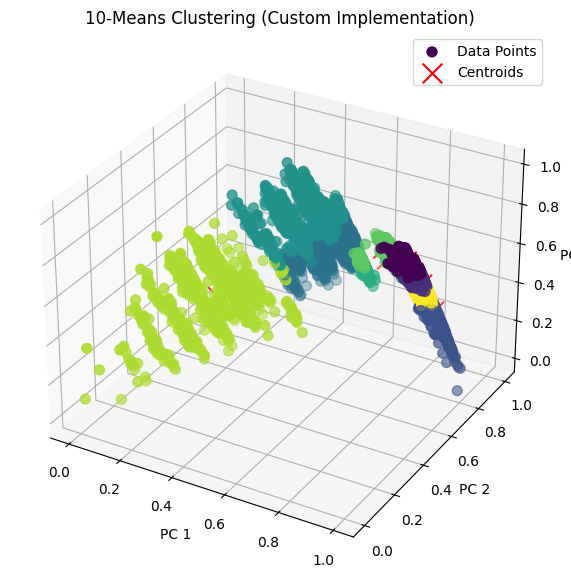

In [288]:
plot_clusters(df_pca, final_label,final_cluster, '10-Means Clustering (Custom Implementation)')

In [289]:
print(len(df2))
clusters=organize_clusters(df2,final_label)

for i in clusters:
    print("Cluster:",i)
    summary=clusters[i]['subscription'].describe()
    print("Summary:",summary)

39999


/tmp/ipykernel_4175846/2077916494.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  clusters[int(label)] = pd.concat([clusters[int(label)], data.iloc[[i]]], ignore_index=True)
/tmp/ipykernel_4175846/2077916494.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  clusters[int(label)] = pd.concat([clusters[int(label)], data.iloc[[i]]], ignore_index=True)
/tmp/ipykernel_4175846/2077916494.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a 

Cluster: 0
Summary: count     5577
unique       2
top         no
freq      5221
Name: subscription, dtype: object
Cluster: 1
Summary: count     10222
unique        2
top          no
freq       9790
Name: subscription, dtype: object
Cluster: 4
Summary: count     2359
unique       2
top         no
freq      1491
Name: subscription, dtype: object
Cluster: 3
Summary: count     9250
unique       2
top         no
freq      7867
Name: subscription, dtype: object
Cluster: 8
Summary: count     6844
unique       2
top         no
freq      6553
Name: subscription, dtype: object
Cluster: 6
Summary: count     1377
unique       2
top         no
freq      1277
Name: subscription, dtype: object
Cluster: 7
Summary: count     1537
unique       2
top        yes
freq       952
Name: subscription, dtype: object
Cluster: 5
Summary: count     2162
unique       2
top         no
freq      2048
Name: subscription, dtype: object
Cluster: 2
Summary: count     671
unique      2
top        no
freq      661
Name: su

In [291]:
for i in clusters:
    print("Cluster:",i)
    df_sub=clusters[i]['subscription']
    clf = DecisionTreeClassifier(criterion='gini')
  
    clf.fit(df_sub.map({'no':0,'yes':1}).values.reshape(-1, 1), df_sub)
    print("Gini",clf.tree_.impurity[0])

Cluster: 0
Gini 0.11951774702633311
Cluster: 1
Gini 0.08095145909890622
Cluster: 4
Gini 0.4651269272424693
Cluster: 3
Gini 0.2543184455807158
Cluster: 8
Gini 0.08142225965244998
Cluster: 6
Gini 0.13469547694276074
Cluster: 7
Gini 0.471492810818293
Cluster: 5
Gini 0.09989722402168133
Cluster: 2
Gini 0.029362052767295754
